In [57]:
# Needed libraries
import pathlib
import pandas as pd 
from rdkit import RDLogger
from matplotlib import pyplot as plt
import sys
sys.path.append('../')
from scripts.data_prep import smiles_cleaning as sc
from scripts.data_prep import feature_cleaning as fc
from scripts.data_prep import featurization
from scripts import regression_models

# PPCHEM Project Report, Ricardo Meireles & Malo Gfeller

In this project, the aim was to create a melting point prediction model and an interface for using the model. The motivations behind this idea are to develop our skills in data science, which is a very valuable skill for the years to come, and to learn how to make a project usable through an interface, as the UX of a tool can sometimes be an obstacle for some of our future collaborators who won't be coding.

## Data collection

In order to recover numerous smiles-melting point pairs, 2 methods were available to us. Use existing datasets or create our own by webscrapping. The latter method makes it difficult to verify sources, which is why we ended up using the "bradleymeltingpoint" dataset, a standard in the field. Scraping the pubchem data will enable us to evaluate the model and identify sources of error of the model predictions.

### Scraping 

On the pubcehm website, all cids of molecules for which at least 1 melting point has been recorded are downloadable. The corresponding data are in PubChem_comp_with_mp_list_.xlsx

As the datasets obtained from this notebook will be used simply to get an idea of the model's performance and not for the training, we will simplify and extract only 1 melting point per molecule, even if sometimes more are registred on pubchem.

To do this, we'll use the extracted cids and the fact that the pages referencing the melting point contain these cids. We will just loop through each page and extract the melting point.

*Note : a scrapping using request and JSON page of each compounds has been tried and is faster, but the JSON path to the melting point is not consistent across all pages.*

In order to run the following code, you will have to configure a webdriver for selenium, more on [ChromeDriver](https://developer.chrome.com/docs/chromedriver?hl=fr). However, this cell takes time to run, so the results are already in a csv file in the data folder. You can simply load it. 

In [7]:
"""
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd

# Load the data
base_df = pd.read_excel("../Data/scrapping/PubChem_comp_with_mp_list_.xlsx")

# Get the list of CID
cid_list = base_df["cid"].to_list()

driver = webdriver.Chrome()

# Initialize a df to store the data
df = pd.DataFrame(columns=['CID', 'mpC'])

# Loop to access each CID URL
for cid in cid_list[:12000]:
    url = f"https://pubchem.ncbi.nlm.nih.gov/compound/{cid}#section=Melting-Point&fullscreen=true"
    driver.get(url)
    
    try:
        # Wait for the Melting Point information to load and extract the melting point
        WebDriverWait(driver, 3).until(
            EC.visibility_of_element_located((By.CSS_SELECTOR, "#Melting-Point .break-words.space-y-1"))
        )
        melting_point = driver.find_element(By.CSS_SELECTOR, "#Melting-Point .break-words.space-y-1").text
        print(f"Accessed page: {url} - Melting Point: {melting_point}")
        
        new_row = pd.DataFrame({'CID': [cid], 'mpC': [melting_point]})
        df = pd.concat([df, new_row], ignore_index=True)
    except Exception as e:
        print(f"Failed to extract melting point for CID {cid}: {e}")
        new_row = pd.DataFrame({'CID': [cid], 'mpC': 'Not Found'})
        df = pd.concat([df, new_row], ignore_index=True)


# Close
driver.quit()
"""
import pandas as pd

#Load the data
pubchem_data = pd.read_csv("../data/scrapping/pubchem_scraped_mpC.csv")

### Training dataset 

The BradleyMeltingPoint dataset has been dowloaded from [FigShare](https://figshare.com/articles/dataset/Jean_Claude_Bradley_Open_Melting_Point_Datset/1031637/2). 

In [4]:
# Set the data path and import the dataset
bradley_data_path = pathlib.Path("../data/model_selection/BradleyMeltingPointDataset.csv")
raw_df = pd.read_csv(bradley_data_path)
raw_df.head(5)

,key,name,smiles,mpC,csid,link,source,donotuse,donotusebecause
0,1,"2-(2,4-dinitrobenzyl)pyridine",c1ccnc(c1)Cc2ccc(cc2[N+](=O)[O-])[N+](=O)[O-],92.0,64018,http://www.alfa.com/en/GP100W.pgm?DSSTK=B24192,Alfa Aesar,NaN,NaN
1,2,2-(1-piperidinyl)aniline,c1ccc(c(c1)N)N2CCCCC2,46.0,403764,http://www.alfa.com/en/GP100W.pgm?DSSTK=A13073,Alfa Aesar,NaN,NaN
2,3,2-(1-piperazinyl)pyrimidine,c1cnc(nc1)N2CCNCC2,33.0,80080,http://www.alfa.com/en/GP100W.pgm?DSSTK=L15884,Alfa Aesar,NaN,NaN
3,4,2-(1-piperazinyl)phenol,c1ccc(c(c1)N2CCNCC2)O,125.0,63701,http://www.alfa.com/en/GP100W.pgm?DSSTK=B20252,Alfa Aesar,NaN,NaN
4,5,2-(1-cyclohexenyl)ethylamine,C1CCC(=CC1)CCN,-55.0,69388,http://www.alfa.com/en/GP100W.pgm?DSSTK=L08261,Alfa Aesar,NaN,NaN


## Data cleaning

To be able to do machine learning, we first had to clean our data.

Firstly, as the dataset contains "donotuse" marker for data that are proven to be wrong, we will delete all row with a marker in the "donotuse" column :

In [5]:
clean_df = raw_df[raw_df['donotuse'].isnull()]

Now, we ensure that the dataset do not contains impossible, non-canonical, or duplicate smiles :

In [6]:
RDLogger.DisableLog('rdApp.error') # Disable error messages from invalid SMILES
unique_df = sc.clean_smiles_dataframe(clean_df, "smiles")
RDLogger.EnableLog('rdApp.error') # Enable error messages back
print(f"The new dataframe has {unique_df.shape[0]} unique SMILES")

Removed 8323 rows with invalid or duplicate SMILES.
The new dataframe has 19945 unique SMILES


To train ML models, we only need the smiles and melting point (Celsius) columns :

In [7]:
final_dataset = unique_df[['smiles', 'mpC']]
final_dataset.shape

(19945, 2)

## Data Analysis

Before generating features and train the model, we can analyze our data to see if there's keypoints to look at for the predicition models. We can verify if different expected trends are observed. For example, we know that H-bond abilities or strongly polarized bond have a significant impact on melting point, let see an histogram of melting point with and without these H-bond abilities or strongly polarized bonds.

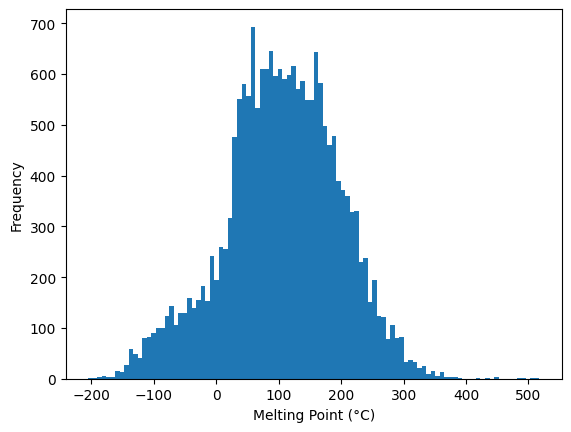

Average melting point: 105.2089275507646


In [12]:
# See the distribution of the melting points using seaborn
plt.hist(final_dataset['mpC'], bins=100)
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.show()

# Print the average melting point
print(f"Average melting point: {final_dataset['mpC'].mean()}")


Now, let's see how it looks without Hbond/polarized bonds. We could use rdkit to calculate if a molecule contains HbondDonnor and HbondAcceptor to be more accurate, but we will simplify here and remove all molecules containing O, N, F atoms with the remove_unwanted_atoms function.

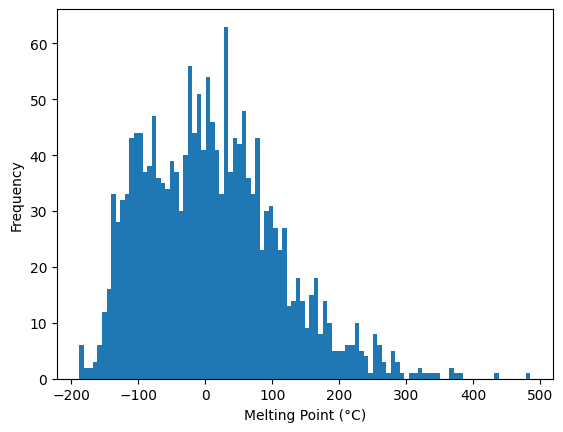

Average melting point: 9.784016949152543


In [13]:
no_Hbond_df = sc.remove_unwanted_atoms(final_dataset, ['O', 'N', 'F'], "smiles")

# See the distribution of the melting points
plt.hist(no_Hbond_df['mpC'], bins=100)
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.show()

# Print the average melting point
print(f"Average melting point: {no_Hbond_df['mpC'].mean()}")

As expected, these kind of compounds have a much lower average melting point.

We therefore know that polarity will be an important point for our prediction model. We can try to find other useful molecular descriptors for the model by looking at the correlation of many molecular descriptors with the melting point.
(Molecular descriptors will be discussed later in "featurization".)

The following function calculate 200 rdkit descriptors for each smiles of the dataframe and add a column per descriptor to the dataframe. The descriptors calculation has already been run. The results are in the data files, you can simply load them :

In [14]:
"""
# Calculate the RDKit descriptors
df_descriptors = featurization.RDkit_descriptors(final_dataset, 'smiles')

#Save the results in a csv file
df_descriptors.to_csv('../Data/model_selection/200rdkit_desc.csv', index=False)
"""
# Load the RDKit descriptors dataset
df_descriptors = pd.read_csv('../data/model_selection/200rdkit_desc.csv')

In [15]:
# Display the top 3 descriptors correlated with the melting point
features = df_descriptors.drop(columns=['smiles', 'mpC'])
target = df_descriptors['mpC']
correlation = features.corrwith(target)
correlation = correlation.abs().sort_values(ascending=False)
correlation.head(3)

BertzCT      0.568399
RingCount    0.533590
TPSA         0.522911
dtype: float64

The 3 most correlated descriptors are BertzCT, RingCount and TPSA. We can see the impact of a descriptor on the melting point with a graph. Let's plot the melting point as a function BertzCT wich is continuous and the RingCount wich is discret.

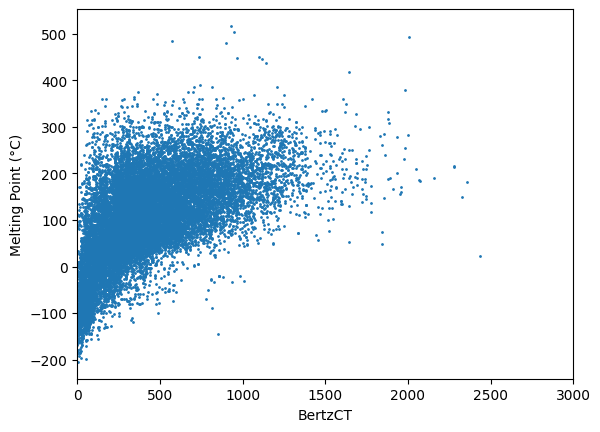

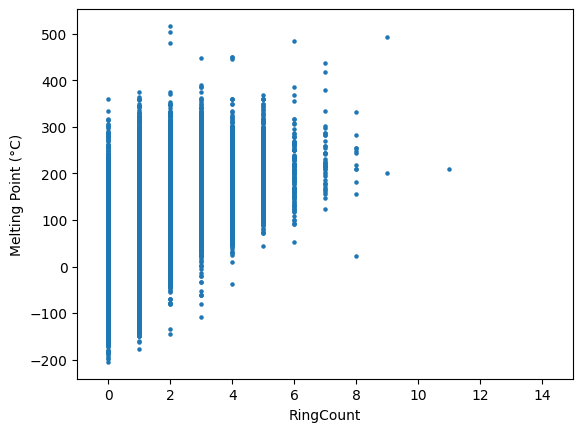

In [17]:
# Plot BertzCT vs Melting Point
plt.scatter(df_descriptors['BertzCT'], df_descriptors['mpC'], s=1)
plt.xlabel('BertzCT')
# Range of the x-axis
plt.xlim(0, 3000)
plt.ylabel('Melting Point (°C)')
plt.show()

# Plot RingCount vs Melting Point
plt.scatter(df_descriptors['RingCount'], df_descriptors['mpC'], s=5)
plt.xlabel('RingCount')
plt.xlim(-1, 15)
plt.ylabel('Melting Point (°C)')
plt.show()

Here we identify another expected trend : the melting point tends to rise with the ring count. Even more, the ring count seems to define a range of possible value for the melting point.

## Featurization

In order to train a model, we need features ; value to describe a molecule that we can input in a mathematical model. To generate these features, there is 2 main choices :
- Descriptors : mordred or rdkit
- Fingerprints : Morgan, MACCS, Topological

We will try all type of fingerprint and rdkit descriptors. 

(We would have liked to try with the Mordred descriptors but they are computationally very demanding and my computer couldn't finish the calculations without stopping. The same problem was encountered when we tried to calculate them in google colab (free version)).

As the following functions take time to execute, this has already been done and the results are in the “data” folder, you can simply load them.

In [51]:
"""
# Calculate the RDKit descriptors
rdkit_desc = featurization.RDkit_descriptors(final_dataset, 'smiles')

# Generate the 3 types of fingerprints
morgan_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='Morgan', n_bits=2048)
maccs_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='MACCS', n_bits=2048)
topo_fgp = featurization.generate_fingerprint_descriptors(final_dataset, smiles_column='smiles', fingerprint_type='Topological', n_bits=2048)
"""

# Load the datasets
rdkit_desc = pd.read_csv('../data/model_selection/200rdkit_desc.csv')
morgan_fgp = pd.read_csv('../data/model_selection/morgan_fgp.csv')
maccs_fgp = pd.read_csv('../data/model_selection/maccs_fgp.csv')
topo_fgp = pd.read_csv('../data/model_selection/topo_fgp.csv')

# Uncomment to see how a dataset looks like
#rdkit_desc.head(3)

We now have in our dataset a *smiles*, *mpC*, and many *descriptors* columns. We have to separate values that we will input in the model (descriptors) and the one that we want to predict. By convention, we name the input **X** and the value to predict **y**.

In [52]:
# Separe mpC and smiles from datasets
y = final_dataset['mpC']
# Drop the mpC and smiles columns to only keep the features
X_rdkit = rdkit_desc.drop(columns=['smiles', 'mpC'])
X_morgan_fgp = morgan_fgp.drop(columns=['smiles', 'mpC'])
X_maccs_fgp = maccs_fgp.drop(columns=['smiles', 'mpC'])
X_topo_fgp = topo_fgp.drop(columns=['smiles', 'mpC'])

Before training different models, we have to clean the features. NaN values can cause trouble during the training step. As fingerprints are just bit vectors, there should not be NaN values in it, but some rdkit descriptors may not have been calculated correctly. Let's check this :

In [53]:
# See if the datasets have NaN values
print(f"rdkit_desc as {X_rdkit.isna().sum().sum()} NaN values")
print(f"X_morgan_fgp as {X_morgan_fgp.isna().sum().sum()} NaN values")
print(f"X_maccs_fgp as {X_maccs_fgp.isna().sum().sum()} NaN values")
print(f"X_topo_fgp as {X_topo_fgp.isna().sum().sum()} NaN values")

RDKit Descriptors has 72 NaN values
Morgan Descriptors has 0 NaN values
MACCS Descriptors has 0 NaN values
Topological Descriptors has 0 NaN values


We see that the rdkit_desc contains NaN values. There's many different ways to [handle missing values in machine learning](https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e), here we will simply fill them with the mean of the descriptors.

*Notes : When we experimented with Mordred descriptors on smaller datasets, we noticed that NaN values were more frequent with these descriptors, which is why the handle_missing_data function has various functionalities, including a threshold of NaN values for a given descriptor at which we simply drop this descriptor.*

In [55]:
X_rdkit = fc.handle_missing_data(X_rdkit, fill_method="mean")

Also, we can clean the features to make the training faster. Removing low variance and highly correlated features has usually no significant impact on the model performance because it is redondant informations :

In [56]:
# Remove low variance features
X_rdkit = fc.remove_low_variance_features(X_rdkit, threshold=0.05)
X_maccs_fgp = fc.remove_low_variance_features(X_maccs_fgp, threshold=0.05)
X_morgan_fgp = fc.remove_low_variance_features(X_morgan_fgp, threshold=0.05)
X_topo_fgp = fc.remove_low_variance_features(X_topo_fgp, threshold=0.05)

## Create the model

Initially, a scaled-down version of the bradleymeltingpoint dataset was used to familiarize ourselves with the different methods in machine learning, while keeping calculation times short.

Many models and hyperparameters have been tried, but the results were often very similar. The following code provides a quick summary of models performance using rdkit descriptors or the 3 fingerprints :

In [34]:
rdkit_perf = regression_models.compare_regression_models(X_rdkit, y)
rdkit_perf

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24439
[LightGBM] [Info] Number of data points in the train set: 15956, number of used features: 199
[LightGBM] [Info] Start training from score 105.178100


,R2 Score,RMSE
XGBoost,0.804990,40.488480
LightGBM,0.799952,41.008158
Random Forest,0.795809,41.430596
Gradient Boosting,0.750958,45.755083
Linear Regression,0.709973,49.376679


In [41]:
"""
morgan_perf = regression_models.compare_regression_models(X_morgan_fgp, y,)
morgan_perf
"""

,R2 Score,RMSE
XGBoost,0.709673,49.402233
Random Forest,0.705037,49.795118
LightGBM,0.694995,50.635638
Linear Regression,0.619239,56.575597
Gradient Boosting,0.592258,58.545750


In [42]:
topo_perf = regression_models.compare_regression_models(X_topo_fgp, y)
topo_perf

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.115271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 15956, number of used features: 2048
[LightGBM] [Info] Start training from score 105.178100


,R2 Score,RMSE
XGBoost,0.705098,49.789985
Random Forest,0.705083,49.791253
LightGBM,0.691794,50.900690
Gradient Boosting,0.588845,58.790288
Linear Regression,0.588499,58.815034


In [ ]:
maccs_perf = regression_models.compare_regression_models(X_maccs_fgp, y)
maccs_perf

,R2 Score,RMSE
XGBoost,0.748467,45.983356
Random Forest,0.741392,46.625505
LightGBM,0.736126,47.097854
Gradient Boosting,0.669470,52.711852
Linear Regression,0.642226,54.841234


In [ ]:
maccs_perf = regression_models.compare_regression_models(X_maccs_fgp, y)
maccs_perf

R² Score: 0.8062
RMSE: 40.0939


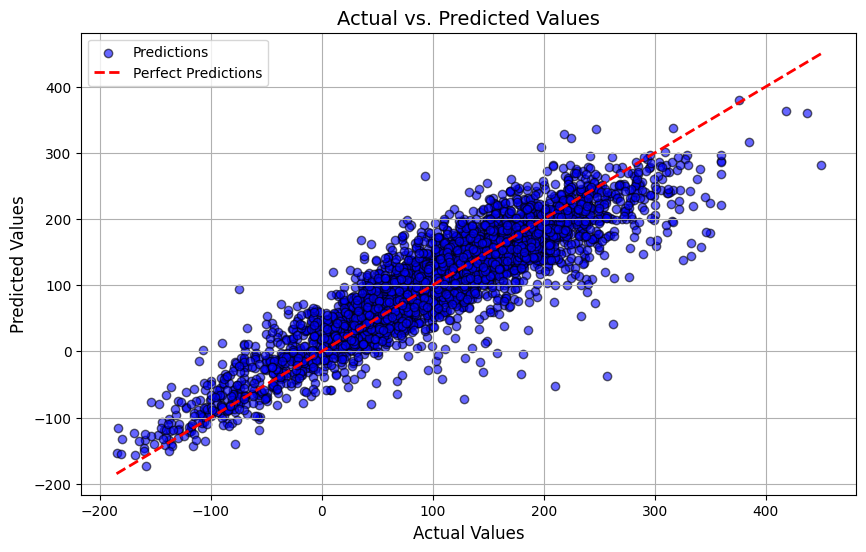

In [29]:
from xgboost import XGBRegressor
regression_models.plot_predictions(XGBRegressor(), X_rdkit, y, test_size=0.2, random_state = 142)

After this, an hyperparameter tunning using a GridSearch has been done for RandomForest with rdkit descriptors but no significant improvement has been observed.

Further research led us to the [Chemprop](https://github.com/chemprop/chemprop) GitHub repository. We tested their MPNN with default parameters on our dataset, and it turned out to be the best performing model. Subsequently, we experimented with various modifications, and incorporating RDKit descriptors showed beneficial for performance. We also tried an ensemble of three models, but no significant improvement in performance was observed.

The data used (corresponding to bradleymeltingpoint cleaned) and data splitting are in the *"data/splitting_for_training"* folder. The training was done using the default arguments with *"--features_generator rdkit_2d_normalized --no_features_scaling"* in addition. 

The best performing epoch was epoch 26/30 with a RMSE of 37.84 on the validation set and of 36.11 on the test set.


    --data_path <data_path> --dataset_type regression --save_dir <save_dir> --split_sizes 0.8 0.1 0.1 --save_smiles_splits --features_generator rdkit_2d_normalized --no_features_scaling 


**test rmse = 36.106023**

___
Then, another training has been done with 3-fold validation using the additional argument : 

	--num_folds 3



**Seed 0 ==> test rmse = 35.984399**

**Seed 1 ==> test rmse = 36.522956**

**Seed 2 ==> test rmse = 35.771262**

This results allows us to assert that the model's performance is not "splitting specific".

As this model is the best performing one, it was chosen as the one to be implemented in the interface and evaluated in greater depth in the second notebook.